In [1]:
import numpy as np 
import pandas as pd
import os
from tqdm import tqdm

# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

In [2]:
float_data = pd.read_csv("../train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values


def extract_features(z):
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1)]

In [3]:
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    
     
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:])]

In [4]:

n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)

Our RNN is based on 12 features


In [5]:

def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets

In [6]:
batch_size = 32


second_earthquake = 50085877
float_data[second_earthquake, 1]

0.0006954822

In [8]:

train_gen = generator(float_data, batch_size=batch_size)

valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)


from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

model = Sequential()
model.add(layers.GRU(96,dropout=0.2, recurrent_dropout=0.4))
#model.add(layers.GRU(96, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 96)                23424     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                970       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 24,405
Trainable params: 24,405
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=adam(lr=0.00005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=100,
                              verbose=0,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=100)

Instructions for updating:
Use tf.cast instead.


In [9]:

import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

#perf_plot(history)

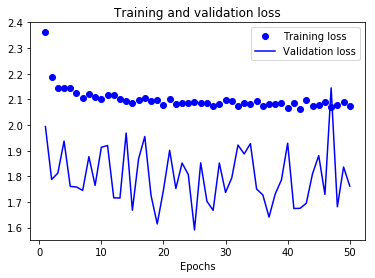

In [10]:
perf_plot(history)

In [11]:

submission = pd.read_csv('../sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})


for i, seg_id in enumerate(tqdm(submission.index)):
  
    seg = pd.read_csv('../test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()


submission.to_csv('submission1.csv')

100%|██████████| 2624/2624 [02:01<00:00, 21.53it/s]
